- https://github.com/teddylee777/langchain-kr/blob/main/17-LangGraph/04-langgraph-search-or-retrieve.ipynb
- https://www.youtube.com/watch?v=4JdzuB702wI&t=1s

# 부족한 정보를 검색하여 Context 보강
### 절차

1. 전통적인 RAG 를 수행
2. 검색된 문서에 답변에 필요한 정보가 부족한 경우 -> “웹 검색”을 위한 쿼리 재작성
3. “웹 검색” 으로 보충된 정보로 답변 도출 시도
4. 새로운 답변으로 관련성 체크 후 재조정/종료 진행

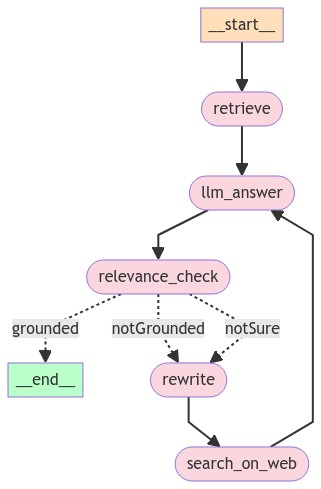

In [ ]:
# api key
from dotenv import load_dotenv

load_dotenv()

LangSmith 설정

In [ ]:
# LangSmith 설정
import os

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="ls__708b8970829247d1a055f33c434aad1d"
os.environ["LANGCHAIN_PROJECT"]="edu-langchain-0326"

LLM 객체 생성

In [ ]:
from langchain_openai import AzureChatOpenAI

# LLM 생성
def Get_LLM():    
    os.environ["AZURE_OPENAI_API_KEY"] = '352a6bee97b5451ab5866993a7ef4ce4'
    os.environ["AZURE_OPENAI_ENDPOINT"] = 'https://aoai-spn-krc.openai.azure.com/'
    model = AzureChatOpenAI(  
      api_version = '2024-02-01',
      azure_deployment = 'gpt-4o-kr-spn',
      temperature = 0.0
    )
    return model

상태 정의

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field

# 관련성 결과 형식
class GradeDocuments(BaseModel):
    """Boolean values to check for relevance on retrieved documents."""

    score: str = Field(
        description="Documents are relevant to the question, 'True' or 'False'"
    )

RAG 수행

In [ ]:
from rag.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

# GraphState
각 노드에서 다음 노드로 전달되는 상태를 저장합니다.

In [ ]:
from typing import TypedDict


# GraphState 상태를 저장하는 용도로 사용합니다.
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # 답변
    relevance: str  # 답변의 문서에 대한 관련성

# 노드와 엣지
우리는 agentic RAG 그래프를 다음과 같이 구성할 수 있습니다:

- 상태는 메시지의 집합입니다
- 각 노드는 상태를 업데이트(추가)합니다
- 조건부 엣지는 다음에 방문할 노드를 결정합니다

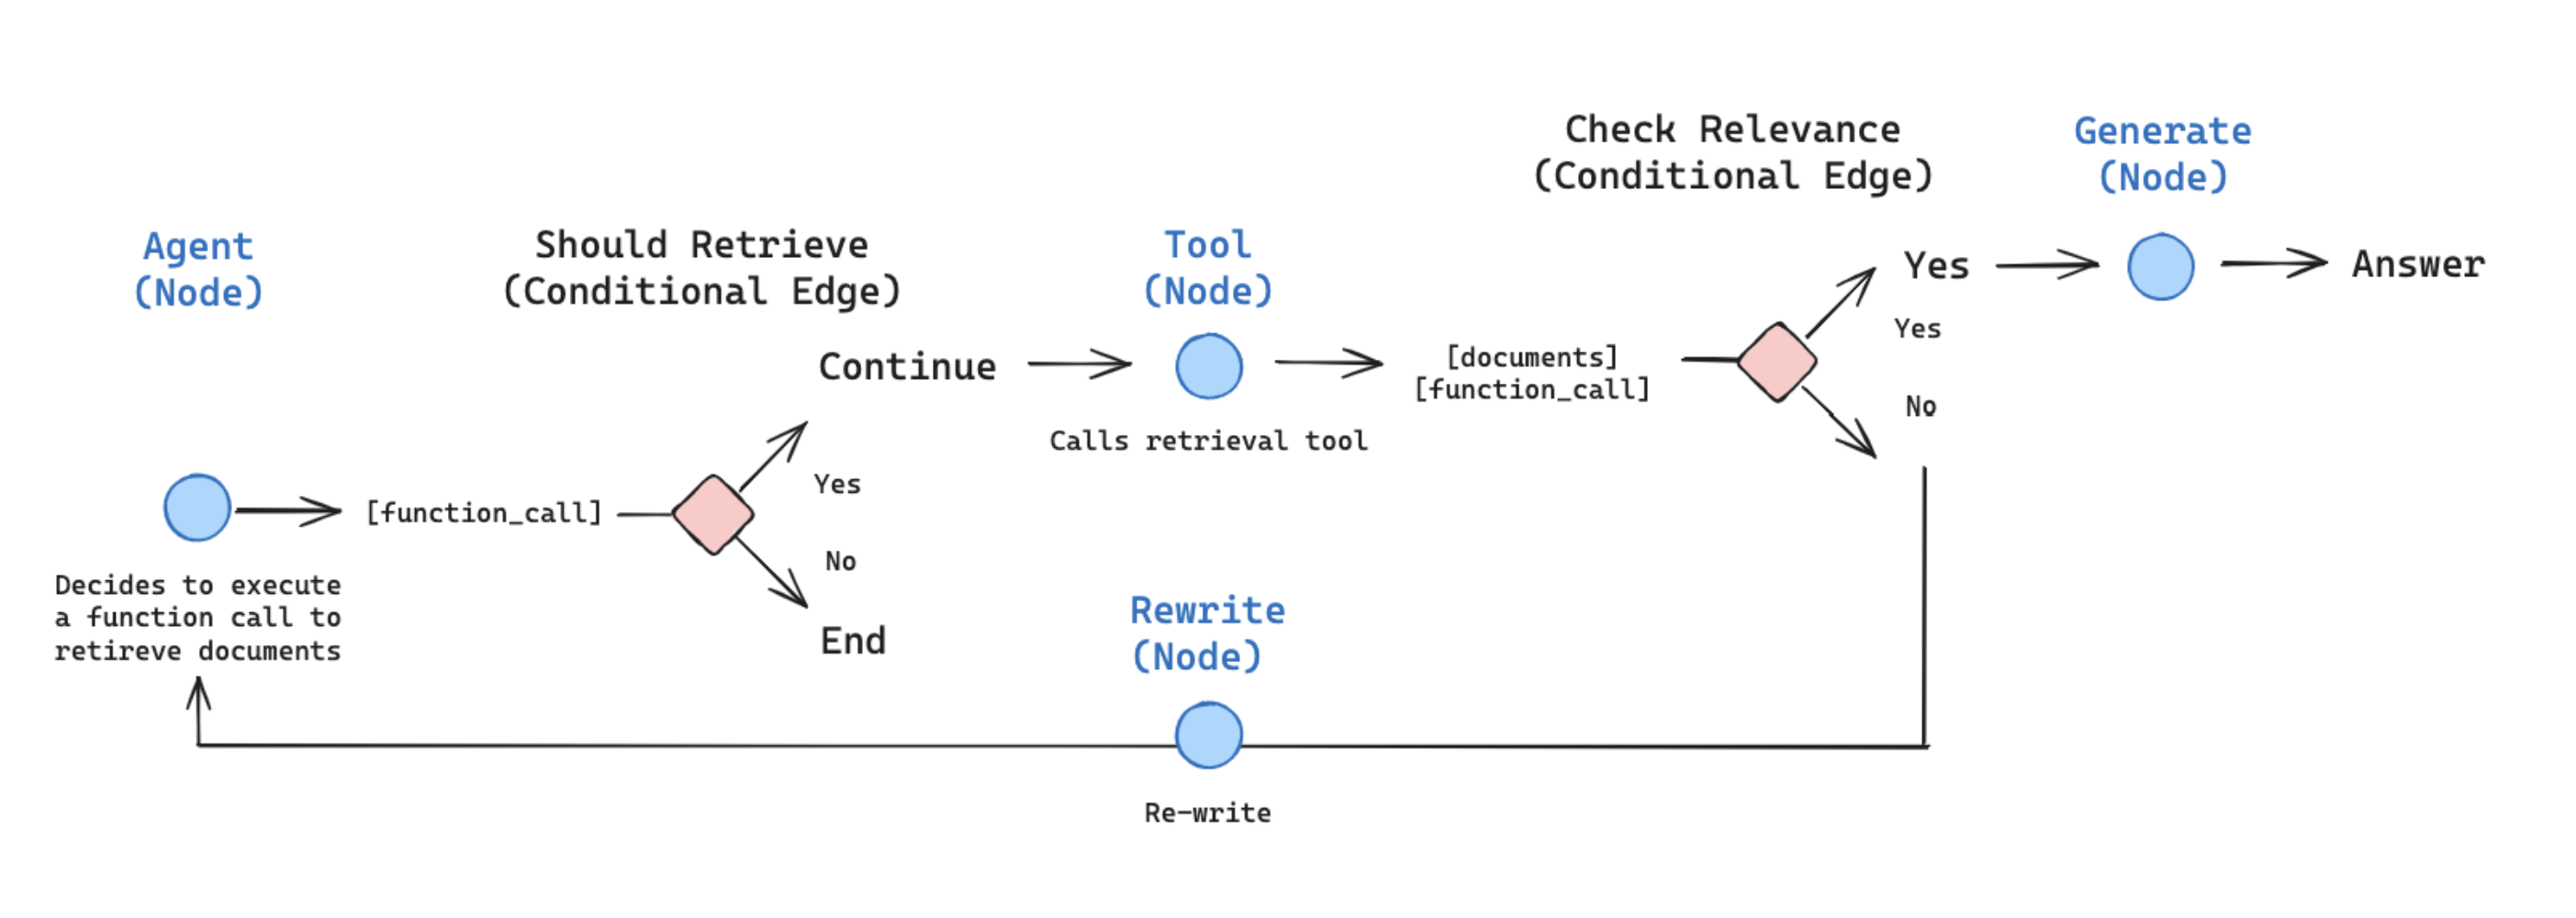

In [ ]:
# from langchain_upstage import UpstageGroundednessCheck
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools.tavily_search import TavilySearchResults
from rag.utils import format_docs, format_searched_docs

# 업스테이지 문서 관련성 체크 기능을 설정합니다. https://upstage.ai
# upstage_ground_checker = UpstageGroundednessCheck()


# 벡터 DB 검색
def retrieve_document(state: GraphState) -> GraphState:
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(state["question"])

    # 검색된 문서를 형식화합니다.
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# LLM을 사용하여 답변을 생성합니다.
def llm_answer(state: GraphState) -> GraphState:
    question = state["question"]
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke({"question": question, "context": context})

    return GraphState(answer=response)

# 질문 재작성
def rewrite(state):
    question = state["question"]
    answer = state["answer"]
    context = state["context"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                # 당신은 전문적인 프롬프트 재작성자입니다. 당신의 임무는 현재 문맥에 표시되지 않은 추가 정보를 얻기 위해 질문을 생성하는 것입니다.
                # 생성한 질문은 웹에서 검색되어 관련 정보를 찾는 데 사용됩니다.
                "You are a professional prompt rewriter. Your task is to generate the question in order to get additional information that is now shown in the context."
                "Your generated question will be searched on the web to find relevant information.",
            ),
            (
                "human",
                # 추가 정보를 얻어 답변을 얻기 위해 질문을 재작성하세요.
                # 여기 초기 질문이 있습니다:
                # 여기 초기 문맥이 있습니다:
                # 여기 질문에 대한 초기 답변이 있습니다:
                # 개선된 질문을 한국어로 작성하세요:
                "Rewrite the question to get additional information to get the answer."
                "\n\nHere is the initial question:\n ------- \n{question}\n ------- \n"
                "\n\nHere is the initial context:\n ------- \n{context}\n ------- \n"
                "\n\nHere is the initial answer to the question:\n ------- \n{answer}\n ------- \n"
                "\n\nFormulate an improved question in Korean:",
            ),
        ]
    )

    # Question rewriting model
    model = Get_LLM()

    chain = prompt | model | StrOutputParser()
    response = chain.invoke(
        {"question": question, "answer": answer, "context": context}
    )
    return GraphState(question=response)

# 웹에서 질문 검색
def search_on_web(state: GraphState) -> GraphState:
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    os.environ["TAVILY_API_KEY"] = "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"
    search_tool = TavilySearchResults(max_results=5)
    search_result = search_tool.invoke({"query": state["question"]})

    # 검색된 문서를 형식화합니다.
    search_result = format_searched_docs(search_result)
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(
        context=search_result,
    )

# 관련성 체크를 실행합니다.
def relevance_check(state: GraphState) -> GraphState:
    doc = state["context"]
    question = state["question"]

    # 시스템 프롬프트:
    # 당신은 사용자의 질문에 대한 검색된 문서의 관련성을 평가하는 평가자입니다. \n
    # 문서가 질문과 관련된 키워드나 의미를 포함하고 있다면, 그 문서를 관련성이 있는 것으로 평가하세요. \n
    # 문서가 질문과 관련이 있는지를 나타내기 위해 'True' 또는 'False'라는 불린 점수를 부여하세요.

    system = """You are a grader assessing relevance of a retrieved document to a user question. \n
        If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
        Give a boolean score 'True' or 'False' score to indicate whether the document is relevant to the question."""

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Retrieved document: \n\n {document} \n\n User question: {question}",
            ),
        ]
    )

    llm = Get_LLM()
    structured_llm = llm.with_structured_output(GradeDocuments)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"document": doc, "question": question})
    return GraphState(
        relevance=result.score,
        answer=state["answer"],
        question=state["question"],
    )


# def relevance_check(state: GraphState) -> GraphState:
#     print("relevance_check", state)
#     # 관련성 체크를 실행합니다. 결과: grounded, notGrounded, notSure
#     response = upstage_ground_checker.run(
#         {"context": state["context"], "answer": state["answer"]}
#     )
#     return GraphState(
#         relevance=response, question=state["question"], answer=state["answer"]
#     )

# 관련성 분기
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"].lower() == "true":
        return "grounded"
    else:
        return "notGrounded"

In [ ]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve_document)  # 에이전트 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 정보 검색 노드를 추가합니다.
workflow.add_node(
    "relevance_check", relevance_check
)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.
workflow.add_node("rewrite", rewrite)  # 질문을 재작성하는 노드를 추가합니다.
workflow.add_node("search_on_web", search_on_web)  # 웹 검색 노드를 추가합니다.

# 각 노드들을 연결합니다.
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", "relevance_check")  # 답변 -> 관련성 체크
workflow.add_edge("rewrite", "search_on_web")  # 재작성 -> 관련성 체크
workflow.add_edge("search_on_web", "llm_answer")  # 웹 검색 -> 답변


# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "grounded": END,  # 관련성이 있으면 종료합니다.
        "notGrounded": "rewrite",  # 관련성이 없으면 다시 답변을 생성합니다.
        # "notSure": "rewrite",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)


workflow.set_entry_point("retrieve")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

In [ ]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [ ]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
)

_question = "삼성에서 개발한 LLM"
# _question = "가우스를 만든 회사의 2023년 매출액"
# _question = "오늘 서울의 날씨를 알려줘"

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(
    question=_question
)

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

In [ ]:
try:
    print("Question: \t", output["relevance_check"]["question"])
    print("Answer: \t", output["relevance_check"]["answer"])
    print("Relevance: \t", output["relevance_check"]["relevance"])
except KeyError as e:
    print("Question: \t", output["rewrite"]["question"])
    print("Answer: \t", "정보를 찾을 수 없습니다.")

